# Определение уязвимых групп населения
## Дипломный проект учебного курса Data Science

## Часть 4. Анализ результатов кластеризации

In [25]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import kruskal, mannwhitneyu, chi2_contingency
from statsmodels.stats.proportion import proportions_chisquare

pd.set_option('display.float_format', '{:.2f}'.format)


from IPython.display import display, HTML, Javascript
display(HTML("<style>.container { width:100% !important; }</style>"))


display(Javascript(
    """
    IPython.OutputArea.prototype._should_scroll = function(lines) {
        return false;
    }
    """
))

%matplotlib inline

data_path = 'C:/Users/admin/Desktop/FDSupportBK/my_projects_DST120/edu_projects/Diploma/ОУГН/social_russia_data/'

<IPython.core.display.Javascript object>

In [26]:
# Функция для добавления ANSI кодов для жирного и синего текста
def make_bold_blue(text):
    return f"\033[1;34m{text}\033[0m"

In [27]:
# Подгрузим наш финальный датафрейм с кластерами
russia_regions_cl = pd.read_excel(data_path + 'russia_regions_clusters.xlsx', index_col='region')

In [28]:
display(russia_regions_cl.head())

,per_capita,real_incomes,formal_wage,real_pay,child_mortality,disabled_18_60,alco,drug,grp,living_area,...,grievous harm,income,subsidies,children,orphanage,adopted_percent,avg_pension,retired_percent,living_wage,Cluster
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,23864,95.50,30072,103.80,97,2060817,88.10,17.40,291156.90,18.00,...,647,130944.12,74306.24,490149,983,59,8064.10,26.80,10904,1
Амурская область,35499,100.30,52430,105.20,42,766768,113.30,24.40,571362.10,17.30,...,255,85583.44,34011.89,178702,676,65,8999.35,22.40,14331,2
Архангельская область,34852,98.40,52779,102.90,27,1016584,64.70,9.20,697648.20,16.90,...,288,95411.95,42447.95,226228,785,60,10876.94,26.40,14507,2
Астраханская область,25199,97.10,38885,104.50,64,520687,22.20,0.20,526950.90,19.20,...,169,52310.99,24050.16,227512,376,66,7713.92,23.90,11287,2
Белгородская область,32841,98.10,37442,104.80,47,2359129,41.30,3.20,646569.00,17.80,...,249,93595.18,35521.91,290694,219,82,8719.47,27.20,10403,2


#### 4.1. Описание кластеров, их характерные особенности в пространстве признаков

In [29]:
cluster_counts = russia_regions_cl['Cluster'].value_counts().sort_index()
print(cluster_counts)

0     8
1    25
2    42
3    10
Name: Cluster, dtype: int64


Для группировки регионов в соответствии с их социально-экономическим благополучием при моделировании были использованы следующие признаки:
- доход на душу населения (per_capita), 
- валовый региональный продукт (grp), 
- общий объем производства товаров и услуг в регионе (reg_prod_total), 
- процент работающего населения (workers_percent), 
- уровень бедности (poverty_percent).

Рассмотрим отличия кластеров по этим характеристикам с помощью полярной диаграммы по медианным значениям. Только заменим reg_prod_total на retail, так как с этим показателем будет интереснее сравнить.

In [30]:
# Нормализуем данные о доходах на душу населения
russia_regions_cl['per_capita_normalized'] = russia_regions_cl['per_capita'] / russia_regions_cl['living_wage']
russia_regions_cl['retail_normalized'] = russia_regions_cl['retail'] / russia_regions_cl['living_wage']

# Выборем интересующие столбцы
cols = ['per_capita_normalized', 'grp', 'retail_normalized', 'workers_percent', 'poverty_percent']

# Сгруппируем по кластерам и вычислим медианы
medians = russia_regions_cl.groupby('Cluster')[cols].median()

# Переименуем столбцы для удобства
medians.rename({
    'per_capita_normalized': 'PerCapita',
    'grp': 'GRP',
    'retail_normalized': 'Retail',
    'workers_percent': 'Workers%',
    'poverty_percent': 'Poverty%'}, 
    axis=1, inplace=True)

# Масштабируем данные
scaler = MinMaxScaler()
medians_scaled = pd.DataFrame(scaler.fit_transform(medians), 
                              columns=medians.columns,
                              index=medians.index)

# Создадим полярные диаграммы для каждого кластера
fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2, 
                   subplot_titles=('Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'))


# Цикл для добавления диаграммы для каждого кластера
for i in range(len(medians_scaled)):
    row = (i // 2) + 1  # Определим строки для текущего кластера
    col = (i % 2) + 1   # Определим столбцы для текущего кластера
    fig.add_trace(go.Scatterpolar(
        r = medians_scaled.iloc[i].values,
        theta = medians_scaled.columns,
        fill='toself',
        name = f'Cluster {i}'
    ), row, col)

# Обновим макет графика
fig.update_polars(radialaxis=dict(range=[0, 1]))
fig.update_layout(
    title="Сравнение кластеров",
    font_size=16,
    showlegend=False,
    autosize=False,
    width=800,
    height=800
)

fig.show()

In [31]:
display('Медианные значения в числовом выражении:', medians)

'Медианные значения в числовом выражении:'

,PerCapita,GRP,Retail,Workers%,Poverty%
Cluster,,,,,
0,3.64,2047106.75,15.09,106.55,7.85
1,2.15,325659.60,14.91,77.70,14.80
2,2.50,534504.40,17.03,82.70,12.15
3,1.84,245720.30,10.50,60.95,23.70


**Кластер_0 - "Богатые регионы"**. Медианные показатели (в расчете на одного человека): зарплата 2.2 прожиточных минимума в месяц, валовый региональный продукт около 345 т.р., годовой объем розничной торговли 15 прожиточных минимумов, 78% работающего населения, 14.9% населения за чертой бедности.

In [33]:
# Выведем эти регионы
cluster_0 = russia_regions_cl[russia_regions_cl['Cluster'] == 0].index
print(make_bold_blue("Регионы в Кластере_0:"), ', '.join(cluster_0))

Регионы в Кластере_0: Магаданская область, Ненецкий автономный округ, Сахалинская область, Ханты-Мансийский автономный округ - Югра, Чукотский автономный округ, Ямало-Ненецкий автономный округ, г. Москва, г. Санкт-Петербург


**Кластер_1 - "На уровне прожиточного минимума"**. Тут наиболее высокие зарплаты, валовый региональный продукт в 5 раз выше среднестатистического, самый высокий процент работающего населения и самый низкий уровень бедности. Одновременно с этим тут средние показатели розничной торговли.

In [35]:
# Выведем эти регионы
cluster_1 = russia_regions_cl[russia_regions_cl['Cluster'] == 1].index
print(make_bold_blue("Регионы в Кластере_1:"), ', '.join(cluster_1))

Регионы в Кластере_1: Алтайский край, Брянская область, Забайкальский край, Ивановская область, Кировская область, Костромская область, Курганская область, Новгородская область, Орловская область, Пензенская область, Псковская область, Республика Бурятия, Республика Карелия, Республика Крым, Республика Марий Эл, Республика Мордовия, Республика Северная Осетия-Алания, Республика Хакасия, Саратовская область, Смоленская область, Ставропольский край, Томская область, Ульяновская область, Чувашская Республика, г. Севастополь


**Кластер_2 - "Выше уровня прожиточного минимума"**. Эти регионы, по-видимому, можно считать наиболее комфортными для жизни в РФ. Заработки выше среднего (хотя и значительно ниже ниже, чем у "богатых регионов"), относительно высокий валовый региональный продукт (соответственно более высокое наполнение региональных бюджетов), самый большой объем розничной торговли, процент бедного населения (12%, лишь чуть ниже, чем у Кластера_0).

In [36]:
# Выведем эти регионы
cluster_2 = russia_regions_cl[russia_regions_cl['Cluster'] == 2].index
print(make_bold_blue("Регионы в Кластере_2:"), ', '.join(cluster_2))

Регионы в Кластере_2: Амурская область, Архангельская область, Астраханская область, Белгородская область, Владимирская область, Волгоградская область, Вологодская область, Воронежская область, Иркутская область, Калининградская область, Калужская область, Камчатский край, Кемеровская область, Краснодарский край, Красноярский край, Курская область, Ленинградская область, Липецкая область, Московская область, Мурманская область, Нижегородская область, Новосибирская область, Омская область, Оренбургская область, Пермский край, Приморский край, Республика Башкортостан, Республика Коми, Республика Саха (Якутия), Республика Татарстан, Ростовская область, Рязанская область, Самарская область, Свердловская область, Тамбовская область, Тверская область, Тульская область, Тюменская область, Удмуртская Республика, Хабаровский край, Челябинская область, Ярославская область


**Кластер_3 - "Бедные регионы"**. Наиболее низкие заработки, валовый региональный продукт, объемы розничной торговли показывает значения в полтора раза меньше чем у среднестатистического и при этом всего 60% работающего населения. Ну и тут конечно же присутствует самый высокий процент населения за чертой бедности (почти вдвое больше среднестатистического). Под среднестатистическими данными здесь понимаем медианные значения для Кластера_0.

In [37]:
# Выведем эти регионы
cluster_3 = russia_regions_cl[russia_regions_cl['Cluster'] == 3].index
print(make_bold_blue("Регионы в Кластере_3:"), ', '.join(cluster_3))

Регионы в Кластере_3: Еврейская автономная область, Кабардино-Балкарская Республика, Карачаево-Черкесская Республика, Республика Адыгея, Республика Алтай, Республика Дагестан, Республика Ингушетия, Республика Калмыкия, Республика Тыва, Чеченская Республика


Предлагаю упорядочить кластера от бедных до богатых. \
То есть так: 
- Кластер_0 - "Бедные регионы", 
- Кластер_1 - "На уровне прожиточного минимума",
- Кластер_2 - "Выше уровня прожиточного минимума", 
- Кластер_3 - "Богатые регионы". 

In [38]:
# Создадим словарь сопоставления для изменения номеров кластеров
cluster_mapping = {
    3: 0,  # Бедные регионы теперь будут иметь номер 0
    1: 1,  # На уровне прожиточного минимума теперь будет 1
    2: 2,  # Выше уровня прожиточного минимума остается 2
    0: 3   # Богатые регионы теперь будут иметь номер 3
}
# Применим сопоставления для изменения номеров кластеров
russia_regions_cl['Cluster'] = russia_regions_cl['Cluster'].map(cluster_mapping)

In [40]:
# Проверим результат
cluster_counts = russia_regions_cl['Cluster'].value_counts().sort_index()
print(cluster_counts)

0    10
1    25
2    42
3     8
Name: Cluster, dtype: int64


Рассмотрим статистическую значимость наблюдаемых различий. Как было показано в Части 3 настоящего проекта, распределения признаков не являются нормальными, а количество сравниваемых групп больше двух. В этом случае можно применить непараметрический критерий Краскела-Уоллиса для проверки гипотезы о том, что несколько выборок имеют одинаковое распределение.

In [41]:
def kruskal_pvalue(df, col):
    # Создаём список для значений из разных кластеров
    cluster_values = [df[df['Cluster'] == cluster][col] for cluster in range(4)]
    # Выполняем тест Краскела-Уоллиса
    stat, p = kruskal(*cluster_values)
    # Возвращаем p-value
    return p

# Список колонок для проверки
cols = ['per_capita_normalized', 'grp', 'retail_normalized', 'workers_percent', 'poverty_percent']

# Выводим результаты для каждой колонки
for col in cols:
    try:
        p_value = kruskal_pvalue(russia_regions_cl, col)
        print(f'{col}: p-value = {p_value:.3f}')
    except ValueError as e:  # Это если, например, в кластере нет данных)
        print(f'{col}: Невозможно вычислить p-value - {e}')

per_capita_normalized: p-value = 0.000
grp: p-value = 0.000
retail_normalized: p-value = 0.000
workers_percent: p-value = 0.000
poverty_percent: p-value = 0.000


p-значения оказались очень маленькими, на уровне 0.000 после округления до трех десятичных знаков. Это означает, что существуют статистически значимые различия между кластерами для каждого из этих показателей. Можно с уверенностью утверждать, что медианные значения этих показателей значимо различаются по кластерам. Это указывает на то, что кластеры имеют уникальные характеристики.

Проверим также справедливость выделения **"Выше уровня прожиточного минимума"** в отдельный Кластер_2 путем сравнения этой группы с Кластером_0 **"На уровне прожиточного минимума"** по критерию Манна-Уитни. Он нам поможет определить, есть ли значимые различия между двумя независимыми выборками.

In [42]:
def mannwhitney_pvalue(df, col, cluster_pair):
    # Извлекаем значения для каждого кластера
    cluster_value_1 = df[df['Cluster'] == cluster_pair[0]][col]
    cluster_value_2 = df[df['Cluster'] == cluster_pair[1]][col]
    
    # Выполняем тест Манна-Уитни и возвращаем p-value
    _, p_value = mannwhitneyu(cluster_value_1, cluster_value_2, alternative='two-sided')
    return p_value

# Список колонок для анализа
cols = ['per_capita_normalized', 'grp', 'retail_normalized', 'workers_percent', 'poverty_percent']

# Выводим p-value для каждой колонки между кластерами 1 и 2
for col in cols:
    p_val = mannwhitney_pvalue(russia_regions_cl, col, (1, 2))
    print(f'{col}: p-value = {p_val:.3f}')

per_capita_normalized: p-value = 0.000
grp: p-value = 0.000
retail_normalized: p-value = 0.001
workers_percent: p-value = 0.000
poverty_percent: p-value = 0.000


Как видим, эти две группы действительно значимо отличаются по всем признакам. Это означает, что вероятность того, что наблюдаемые различия в данных переменных могли возникнуть случайно, очень мала.

#### 4.2. Группы населения, сталкивающиеся с бедностью

В нашем распоряжении есть непосредственная статистика о распределении малоимущего населения по социально-демографическим группам. Ниже эта статистика дана в виде графика по регионам (дополнительно они упорядочены по кластерам слева направо). Некоторые вариации присутствуют, однако существенных отличий между регионами, а также между кластерамии (левая и правая части графика) не наблюдается. Основной состав малоимущего населения - это люди трудоспособного возраста (56%) и дети (39%). На пенсионеров приходится около 5%. Однако эти показатели ничего не говорят о проценте малоимущих внутри каждой из социально-демографических групп (например сколько процентов пенсионеров находятся за чертой бедности - посмотрим дальше).

In [43]:
cols = ['the poor: children', 'the poor: employable', 'the poor: retired']
russia_regions_cl[cols].mean()

the poor: children     39.00
the poor: employable   55.70
the poor: retired       5.48
dtype: float64

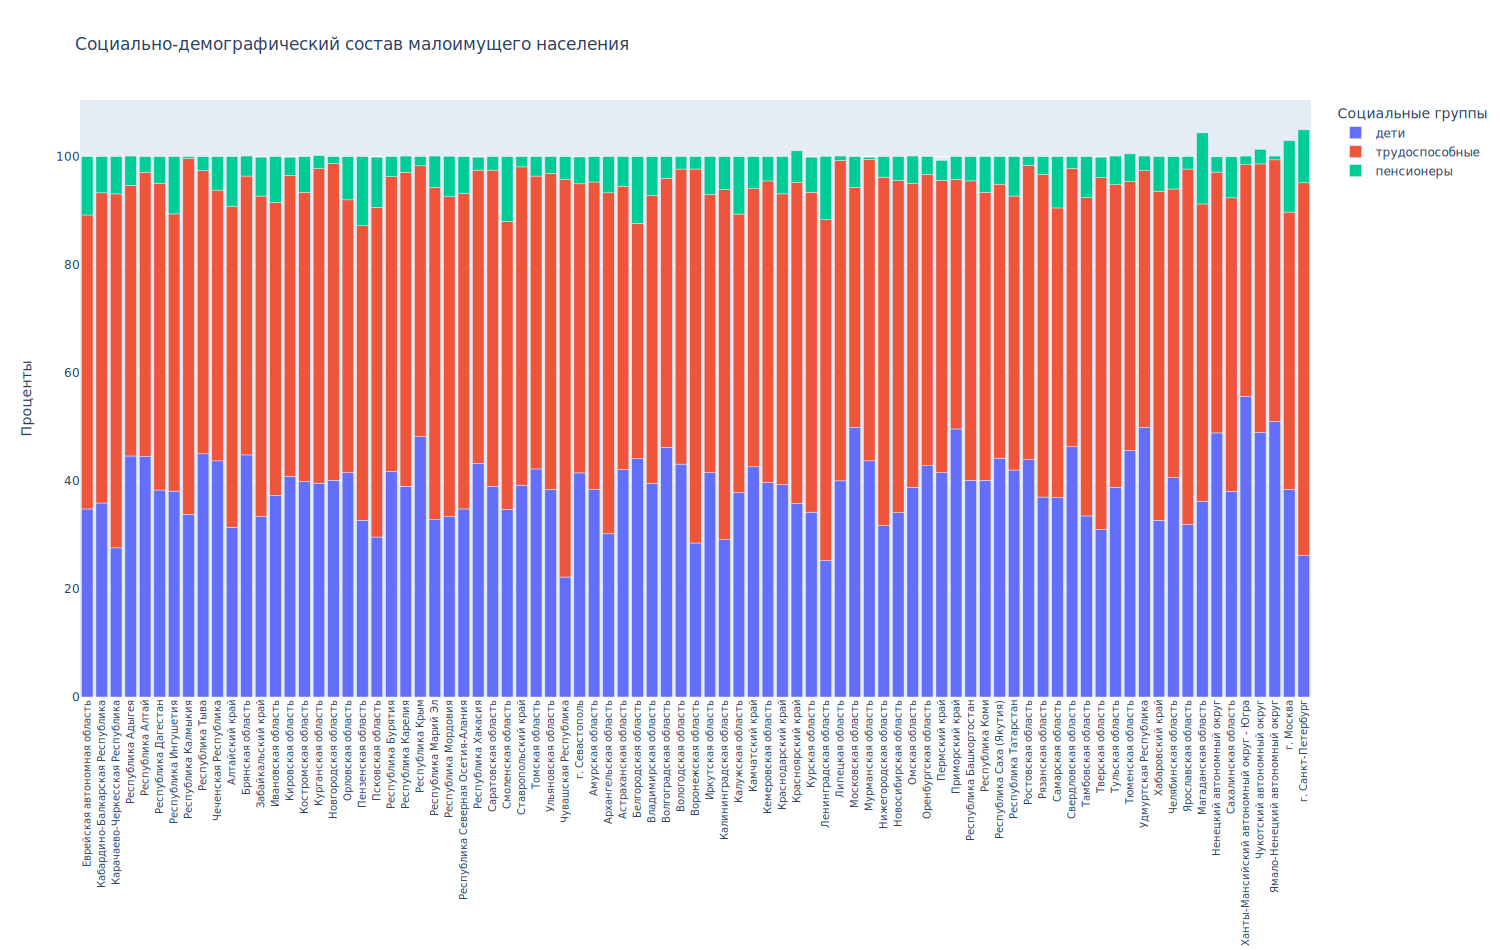

In [44]:
# Сбросим индекс, так как 'region' будет использован для сортировки
plot_df = russia_regions_cl.reset_index().sort_values(by=['Cluster', 'region'])

# Переименовываем столбцы
plot_df = plot_df.rename({
    'the poor: children': 'дети',
    'the poor: employable': 'трудоспособные',
    'the poor: retired': 'пенсионеры' 
}, axis=1)

# Создаем график
fig = px.bar(plot_df, x='region', y=['дети', 'трудоспособные', 'пенсионеры'], width=1500, height=950,
    title='Социально-демографический состав малоимущего населения')
fig.layout.xaxis.tickfont.size = 10
fig.update_xaxes(tickangle=270, title=None)
fig.update_yaxes(title='Проценты')
fig.layout.legend.title = 'Социальные группы'
fig.show('svg')

Рассчитаем процент малоимущих в социально-демографических группах.

In [45]:
# Найдем children_percent для наших дальнейших вычислений
russia_regions_cl['children_percent'] = russia_regions_cl['children'] / russia_regions_cl['population'] * 100

# Создадим датафрейм из копию определенных колонок датафрейма russia_regions_cl
socgroups = russia_regions_cl[[
    'population', 'poverty_percent', 'the poor: children',
    'the poor: retired', 'the poor: employable', 'children',
    'children_percent', 'retired_percent']].copy()

# Процент трудоспособных
socgroups['employable_percent'] = (100 - socgroups['children_percent'] - socgroups['retired_percent']) 

# Количество малоимущих
socgroups['the_poor'] = (socgroups['population'] * socgroups['poverty_percent'] / 100).round(0).astype(int)  

# Количество людей в социально-демографических группах
# 'children' нам уже известно
# Найдем остальных
socgroups['employable'] = ((socgroups['population'] * socgroups['employable_percent'] / 100).round(0).astype(int))  
socgroups['retired'] = ((socgroups['population'] * socgroups['retired_percent'] / 100).round(0).astype(int))  

# Количество малоимущих в социально-демографических группах
socgroups['poor_children'] = ((socgroups['the_poor'] * socgroups['the poor: children'] / 100).round(0).astype(int))
socgroups['poor_employable'] = ((socgroups['the_poor'] * socgroups['the poor: employable'] / 100).round(0).astype(int))   
socgroups['poor_retired'] = ((socgroups['the_poor'] * socgroups['the poor: retired'] / 100).round(0).astype(int))    

# Процент малоимущих в социально-демографических группах
socgroups['poor_children_percent'] = ((socgroups['poor_children'] / socgroups['children'] * 100))  
socgroups['poor_employable_percent'] = ((socgroups['poor_employable'] / socgroups['employable'] * 100))  
socgroups['poor_retired_percent'] = ((socgroups['poor_retired'] / socgroups['retired'] * 100))  

# Среднее по РФ
cols =['poor_children_percent', 'poor_employable_percent', 'poor_retired_percent']
poor_percent = socgroups[cols].mean()

# Посмотрим на результат
print(poor_percent)

poor_children_percent     24.86
poor_employable_percent   14.56
poor_retired_percent       3.47
dtype: float64


В среднем по стране за чертой бедности находятся 25% детей, 14% трудоспособного населения и около 3% пенсионеров. Данная статистика свидетельствует о том, что малоимущими чаще оказываются семьи с детьми - видим большой процент малоимущих среди детей при гораздо меньшем проценте малоимущих среди трудоспособного населения. При этом трудоспособные составляют 56% малоимущего населения - больше чем дети (39%), т.е. многие из малоимущих оказываются в бедственном положении уже при рождении первого ребенка (т.к. оба родителя переходят в разряд малоимущих).

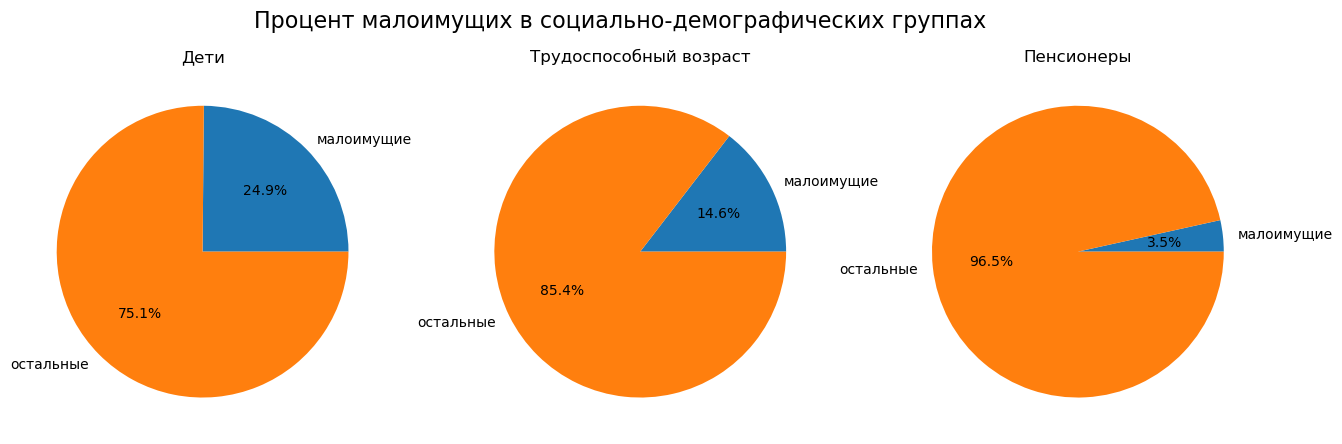

In [46]:
# Визуализируем получившиеся результаты
# Запишем названия для каждого сектора
labels = ['малоимущие', 'остальные']

# Запишем названия для каждого графика
titles = ['Дети', 'Трудоспособный возраст', 'Пенсионеры']

# Создадим фигуры с осями
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Создадим круговые диаграммы
for i, ax in enumerate(axes):
    ax.pie([poor_percent[i], 100-poor_percent[i]], labels=labels, autopct='%1.1f%%')
    ax.set_title(titles[i])

# Добавим общий заголовок
fig.suptitle('Процент малоимущих в социально-демографических группах', fontsize=16)

# Установим белый фон для фигуры
fig.patch.set_facecolor('white')

# Посмотрим на результат
plt.show()

Посмотрим на аналогичные показатели по кластерам. Помимо закономерного падения процента малоимущих от кластера 0 к кластеру 3 (уровень бедности закладывался как признак кластеризации), можно отметить также значительно больший процент малоимущих пенсионеров в беднейших регионах: 10%, в то время как во всех остальных кластерах он не превышает 3%.

In [47]:
# Добавим Cluster в датафрейм socgroups
socgroups['Cluster'] = russia_regions_cl['Cluster']

# Вычислим суммы по группам
cluster_socgroups = (socgroups.groupby('Cluster')[['children', 'employable', 'retired', 'poor_children', 'poor_employable', 'poor_retired']].sum())

# Рассчитаем процентные соотношения малоимущих
cluster_socgroups['poor_children_percent'] = (cluster_socgroups['poor_children'] / cluster_socgroups['children'] * 100)  
cluster_socgroups['poor_employable_percent'] = (cluster_socgroups['poor_employable'] / cluster_socgroups['employable'] * 100)  
cluster_socgroups['poor_retired_percent'] = (cluster_socgroups['poor_retired'] / cluster_socgroups['retired'] * 100) 

# Посмотрим на результат
display(cluster_socgroups)

,children,employable,retired,poor_children,poor_employable,poor_retired,poor_children_percent,poor_employable_percent,poor_retired_percent
Cluster,,,,,,,,,
0,2294803,4361266,1214546,798137,1135355,117092,34.78,26.03,9.64
1,5680833,14878885,7341142,1567943,2419056,220438,27.60,16.26,3.00
2,18550131,48664503,22744413,4172292,5734833,546859,22.49,11.78,2.40
3,3844605,11851455,5322008,489654,714358,138742,12.74,6.03,2.61


#### 4.3. Взаимосвязь численности социально-демографических групп с уровнем бедности

,children,employable,retired,poor_children,poor_employable,poor_retired,poor_children_percent,poor_employable_percent,poor_retired_percent,population,children_percent,employable_percent,retired_percent
Cluster,,,,,,,,,,,,,
0,2294803,4361266,1214546,798137,1135355,117092,34.78,26.03,9.64,7870615,29.16,55.41,15.43
1,5680833,14878885,7341142,1567943,2419056,220438,27.60,16.26,3.00,27900860,20.36,53.33,26.31
2,18550131,48664503,22744413,4172292,5734833,546859,22.49,11.78,2.40,89959047,20.62,54.10,25.28
3,3844605,11851455,5322008,489654,714358,138742,12.74,6.03,2.61,21018068,18.29,56.39,25.32


Есть основания отклонить нулевую гипотезу: процент детей в разных кластерах не одинаков
Chi-square test p-value = 0.000


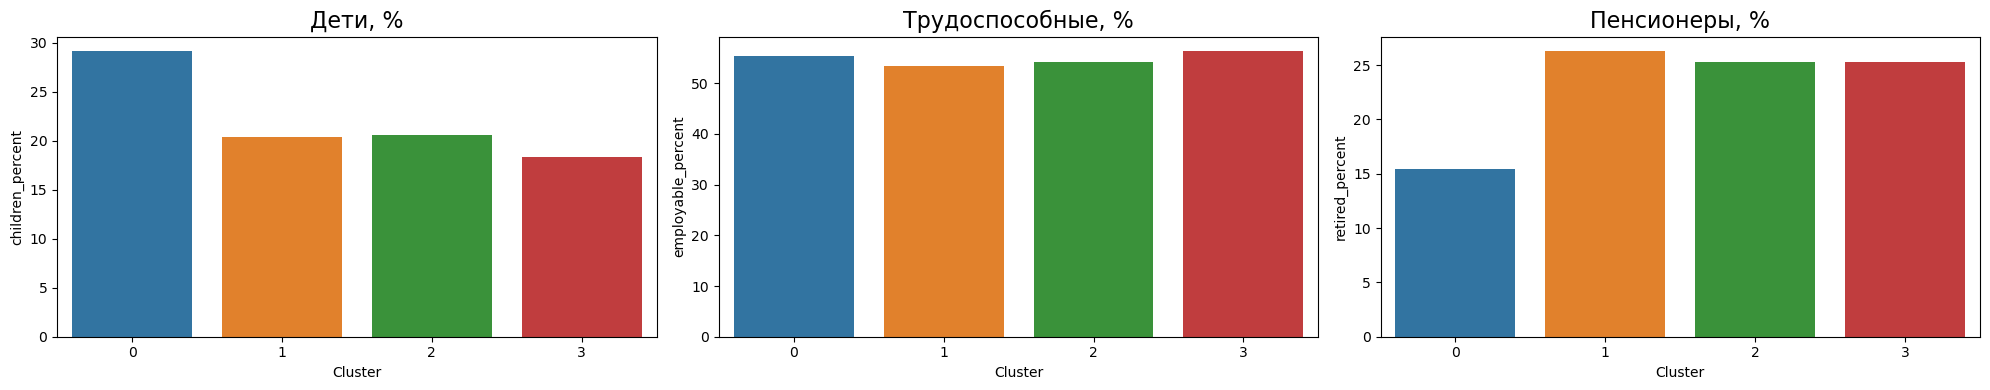

In [48]:
# Расчёт суммы населения и процентов для категорий
cluster_population = russia_regions_cl.groupby('Cluster')['population'].sum().astype(int)
cluster_socgroups = cluster_socgroups.assign(
    population=cluster_population,
    children_percent=cluster_socgroups['children'] / cluster_population * 100,
    employable_percent=cluster_socgroups['employable'] / cluster_population * 100,
    retired_percent=cluster_socgroups['retired'] / cluster_population * 100
)

# Выводим полученную таблицу
display(cluster_socgroups)

# Визуализируем результаты
categories = ['children_percent', 'employable_percent', 'retired_percent']
titles = ['Дети, %', 'Трудоспособные, %', 'Пенсионеры, %']

fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for ax, category, title in zip(axes, categories, titles):
    sns.barplot(data=cluster_socgroups, x=cluster_socgroups.index, y=category, ax=ax)
    ax.set_title(title, fontsize=16)

# Проверка гипотезы
# Построим таблицу сопряженности для хи-квадрат теста
observed = cluster_socgroups[['children', 'population']]
chi2, p, dof, expected = chi2_contingency(observed)

# Интрепретируем p-value
if p < 0.05:
    print("Есть основания отклонить нулевую гипотезу: процент детей в разных кластерах не одинаков")
else:
    print("Нет оснований отклонить нулевую гипотезу: нет убедительных доказательств различий в проценте детей между кластерами")
print(f'Chi-square test p-value = {p:.3f}')

plt.tight_layout()
plt.show()


Из таблицы выше видим, что существенных отличий в процентах трудоспособного населения не наблюдается: величины колеблются в пределах 54% - 56%, такие различия в рабочей силе вряд ли оказывают какое-либо влияние на экономику регионов, особенно в виду кратной разницы в уровне доходов (это можно найти на графиках в Части 3). Одновременно можно отметить, что в беднейших регионах наблюдается существенно больший процент детей (на 10% больше среднего) и меньший процент пенсионеров (тоже на 10%). Процент детей в целом падает с ростом финансового благополучия (от кластера 0 к кластеру 3). Различия статистически значимы:  𝜒2-тест на пропорции дает p-value = 0. Это в целом соответствует полученному ранее выводу о том, что семьи с детьми являются наиболее уязвимым слоем населения с финансовой точки зрения. Одновременно можно предположить, что в более бедных регионах выше рождаемость, что оказывает дополнительное негативное влияние на показатели дохода на душу населения. 

Есть основания отклонить нулевую гипотезу: рождаемость зависит от кластера
Kruskal-Wallis p-value = 0.001


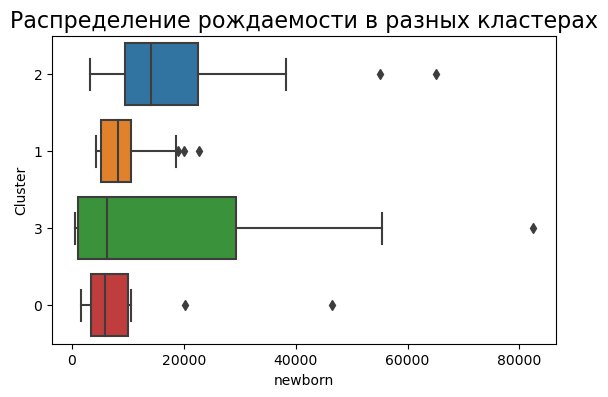

In [49]:
# Считаем медиану для каждого кластера
median_values = russia_regions_cl.groupby('Cluster')['newborn'].median().sort_values(ascending=False)

# Создаем порядок кластеров на основе отсортированных медиан
sorted_clusters = median_values.index.tolist()

# Рассчитываем p-value для теста Краскела-Уоллиса
groups = [group['newborn'].values for name, group in russia_regions_cl.groupby('Cluster')]
p_value = kruskal(*groups).pvalue

# Интерпретируем p-value
if p_value < 0.05:
    print("Есть основания отклонить нулевую гипотезу: рождаемость зависит от кластера")
else:
    print("Нет оснований отклонить нулевую гипотезу: нет убедительных доказательств различий в рождаемости между кластерами")

# Выводим p-value
print(f"Kruskal-Wallis p-value = {p_value:.3f}")

# Теперь строим boxplot с учетом порядка кластеров
plt.figure(figsize=(6.5, 4))
sns.boxplot(data=russia_regions_cl, x='newborn', y='Cluster', orient='h', order=sorted_clusters)
plt.title('Распределение рождаемости в разных кластерах', fontsize=16)

# Отображаем результаты
plt.show()


Видим что:
- Кластер 2: Имеет меньший ящик с усами по сравнению с кластером 3, что указывает на меньший разброс значений рождаемости. Медиана в этом кластере самая высокая, что может свидетельствовать о благоприятных общих условиях для рождения детей в этих регионах. Относительно высокая медиана с меньшим разбросом значений может указывать на более однородные и стабильные условия.

- Кластер 1: Ящик с усами самый маленький и медиану, которая ниже, чем у кластера 2, но выше, чем у кластеров 3 и 0. Это может указывать на наименьшее разнообразие для рождаемости, но с более низким средним уровнем рождаемости по сравнению с кластером 2.

- Кластер_3: Ящик с усами является самым большим, что свидетельствует о значительном разбросе значений рождаемости. То есть, регионы внутри этого кластера могут сильно различаться по уровню рождаемости. Это может быть обусловлено рядом факторов, таких как различия в доступе к медицинским услугам, социальной поддержке и экономическом развитии. В то же время, медиана не является самой высокой, что указывает на то, что, несмотря на наличие регионов с высокой рождаемостью, средний уровень рождаемости в кластере не самый высокий.

- Кластер 0:  Ящик с усами чуть больше чему кластера 1 и медиана самая низкая из всех, что свидетельствует о разнообразие условий для рождаемости и в то же время наименьшем уровне рождаемости. Это может отражать более сложные социально-экономические условия или более высокий уровень урбанизации, который часто сопряжен с более низкой рождаемостью.

- Во всех кластерах присутствуют выбросы, что может указывать на наличие регионов с аномально высокой или низкой рождаемостью по сравнению с медианой кластера.

#### 4.4. Другие различия между кластерами

Рассмотрим прочие отличия между кластерами. Для этого выберем в датафрейме колонки, которые еще не рассматривались, из них выберем только те, которые показывают статистически значимые различия между кластерами на уровне 5% по критерию Краскела-Уоллиса. Отметим, что даже статистически значимые различия не являются доказательством прямой взаимосвязи между уровнем финансового благополучия (кластером) и рассматриваемой характеристикой, однако такой анализ позволяет выдвинуть определенные гипотезы. Дополнительно нормируем некоторые показатели на 100 тыс. населения для учета разной численности населения в регионах.

In [50]:
# Проведем нормировку к пенсии на размер потребительской корзины
russia_regions_cl['avg_pension_normalized'] = russia_regions_cl['avg_pension'] / russia_regions_cl['living_wage']

# Нам необходимо преобразовать данные в колонке adopted_percent в числовые перед функцией kruskal_pvalue
russia_regions_cl['adopted_percent'] = pd.to_numeric(russia_regions_cl['adopted_percent'], errors='coerce')

# После преобразования у нас есть NAN-значения, с которыми нужно поработать
median_value = russia_regions_cl['adopted_percent'].median()
russia_regions_cl['adopted_percent'].fillna(median_value, inplace=True)


# Пересчитаем кол-во преступлений на 100 тыс. населения
russia_regions_cl['registered crimes'] = (russia_regions_cl['registered crimes'] / russia_regions_cl['population'] * 100_000)
russia_regions_cl['felonies'] = (russia_regions_cl['felonies'] / russia_regions_cl['population'] * 100_000)
russia_regions_cl['misdemeanors'] = (russia_regions_cl['misdemeanors'] / russia_regions_cl['population'] * 100_000)
russia_regions_cl['killed'] = (russia_regions_cl['killed'] / russia_regions_cl['population'] * 100_000)
russia_regions_cl['grievous harm'] = (russia_regions_cl['grievous harm'] / russia_regions_cl['population'] * 100_000)

# Кол-во детей в детских домах на 100 тыс. населения
russia_regions_cl['orphanage'] = (russia_regions_cl['orphanage'] / russia_regions_cl['population'] * 100_000)

# Список колонок для анализа
cols = ['child_mortality', 'disabled_18_60', 'alco', 'drug',
        'bad_conditions', 'no_funds', 'general_morbidity',
        'congenital_malformation', 'mental_disorders',
        'teenage_pregnancy', 'population', 'subsidies', 'welfare', 
        'registered crimes', 'felonies', 'misdemeanors', 'killed',
        'grievous harm', 'orphanage', 'adopted_percent', 'avg_pension',
        'avg_pension_normalized', 'living_wage'
]
    
# Скопируем список колонок   
cols_s = cols.copy()

# Пройдем по списку колонок и проводим статистический тест
for col in cols:
    p = kruskal_pvalue(russia_regions_cl, col)
    print(f'{col}: p-value = {p:.3f}')
    # Удаляем колонки с p-value больше 0.05
    if p > 0.05: 
        cols_s.remove(col)

child_mortality: p-value = 0.005
disabled_18_60: p-value = 0.000
alco: p-value = 0.055
drug: p-value = 0.537
bad_conditions: p-value = 0.923
no_funds: p-value = 0.024
general_morbidity: p-value = 0.000
congenital_malformation: p-value = 0.085
mental_disorders: p-value = 0.000
teenage_pregnancy: p-value = 0.027
population: p-value = 0.000
subsidies: p-value = 0.072
welfare: p-value = 0.000
registered crimes: p-value = 0.259
felonies: p-value = 0.056
misdemeanors: p-value = 0.097
killed: p-value = 0.641
grievous harm: p-value = 0.653
orphanage: p-value = 0.291
adopted_percent: p-value = 0.382
avg_pension: p-value = 0.000
avg_pension_normalized: p-value = 0.081
living_wage: p-value = 0.000


Кластеры НЕ отличаются по следующим характеристикам (показатели нормированы на 100 тыс. населения либо приведены в процентах):
- drug: Нет достаточных доказательств наличия различий в употреблении наркотиков.
- bad_conditions: Нет достаточных доказательств наличия различий в проживании в плохих условиях.
- felonies: Нет достаточных доказательств наличия различий в получении субсидий.
- registered crimes: Нет достаточных доказательств наличия различий в количестве зарегистрированных преступлений.
- misdemeanors: Нет достаточных доказательств наличия различий в количестве правонарушений.
- killed: Нет достаточных доказательств наличия различий в количестве убийств.
- grievous harm: Нет достаточных доказательств наличия различий в количестве тяжких телесных повреждений.
- orphanage: Нет достаточных доказательств наличия различий в численности детей в детских домах.
- adopted_percent: Нет достаточных доказательств наличия различий в проценте усыновленных детей.

А также исключаем признаки:
- alco: p-value = 0.055
- congenital_malformation: p-value = 0.085
- subsidies: p-value = 0.072
- felonies: p-value = 0.056
- misdemeanors: p-value = 0.097
- avg_pension_normalized: p-value = 0.081

Остальные признаки имеют p-value ниже 0.05, что указывает на их потенциальную важность для различения кластеров.

In [53]:
# Предположим, что cols_s — это список признаков для визуализации
# Убедимся, что количество признаков соответствует количеству подграфиков
print(f"Количество признаков для визуализации: {len(cols_s)}")

# Теперь давайте вычислим подходящее количество строк и столбцов для подграфиков
# Используя корень квадратный, округление в большую сторону, чтобы вместить все признаки
import math
n_features = len(cols_s)
n_cols = math.ceil(math.sqrt(n_features))
n_rows = math.ceil(n_features / n_cols)

print(f"Мы будем использовать {n_rows} строки(и) и {n_cols} столбец(а) для подграфиков.")

Количество признаков для визуализации: 10
Мы будем использовать 3 строки(и) и 4 столбец(а) для подграфиков.


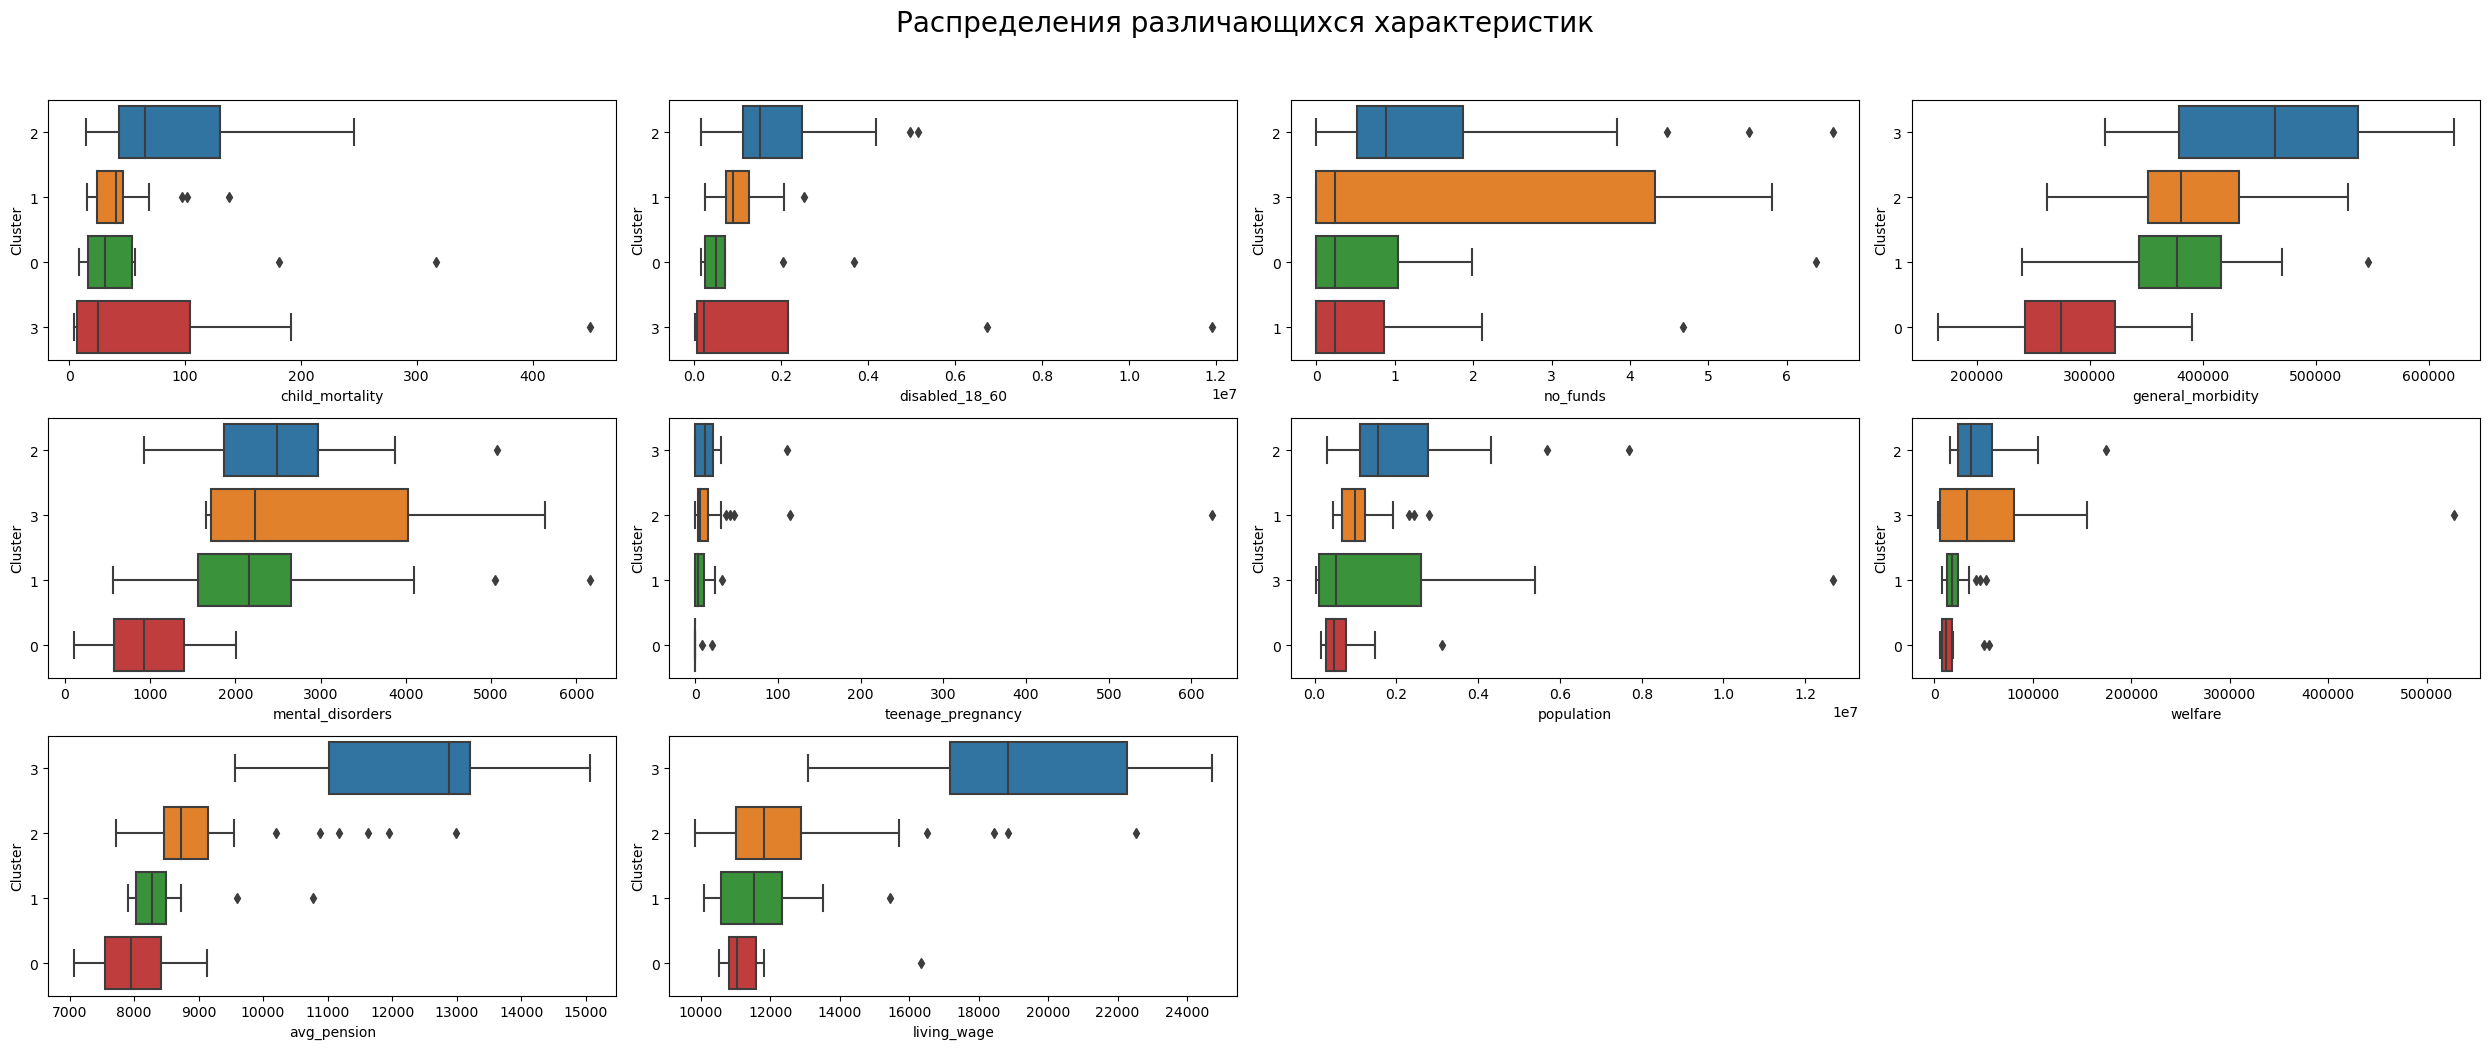

In [54]:
fig, axs = plt.subplots(3, 4, figsize=(25, 11)) # Создаем сетку подграфиков 3x4

# Пройдемся по всем ячейкам сетки подграфиков
for idx, ax in enumerate(axs.flat):
    if idx < len(cols_s):  # Убедимся, что индекс находится в пределах списка признаков
        # Рассчитываем медиану для текущего признака
        median_order = russia_regions_cl.groupby('Cluster')[cols_s[idx]].median().sort_values(ascending=False).index
        # Строим boxplot с учетом отсортированного порядка
        sns.boxplot(data=russia_regions_cl, x=cols_s[idx], y='Cluster', orient='h', ax=ax, order=median_order)
    else:
        ax.set_visible(False)  # Скрываем пустые подграфики

# Установим общий заголовок для всей фигуры
fig.suptitle('Распределения различающихся характеристик', fontsize=20)

# Автоматически подгоним подложку каждого подграфика
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Учитываем место для заголовка

# Посмотрим на результат
plt.show()

Ящики с усами представлены в порядке сортировки по убыванию от большего к меньшему. 
Как мы можем видить картина совсем разнообразная и порой удивительная. 

Можем наглядно теперь увидеть социально-экономическое разделение между кластерами: бедные регионы страдают от высоких уровней проблем, связанных со здоровьем и социальным благополучием, в то время как богатые регионы показывают лучшие показатели. Это может указывать на необходимость адресной социальной и экономической политики для улучшения условий в бедных и менее благополучных регионах.

### Вывод

Дано описание характерных особенностей полученных кластеров:
- бедные регионы;
- регионы на уровне прожиточного минимума;
- регионы выше уровня прожиточного минимума;
- богатые регионы.

Проведен анализ социально-демографических групп населения, показывающий, что наиболее уязвимой группой населения по финасовым показателям являются семьи с детьми. 
 
Также проведен анализ различия других характеристик датафрейма по кластерам. Подробное описание имеющихся корреляций и отсутствия таковых дано выше.